<a href="https://colab.research.google.com/github/Adityachauhan2344/Adityachauhan2344/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pyod
import os
import numpy as np
from pyod.models import hbos
from pyod.utils.data import evaluate_print
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185331 sha256=3e7b22d9c84355f290dcf2e4ed7f0d4f6f82a832ba97da5e6b97ce6a4e1f0639
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [2]:



channels = 32
seconds = 0.5
fs = 256.0
data_portion = 1
save_model = False

In [3]:
import os

# Replace 'new_directory' with the desired name of the new directory
new_directory = "../input/eeg-dataset/"

# Create the new directory in the current working directory (usually '/content/')
os.makedirs(new_directory, exist_ok=True)


In [7]:
import shutil

# Replace 'features_raw.csv' with the file name and path of the file you want to move
file_to_move = '/content/features_raw.csv (1).zip'

# Replace '../input/eeg-dataset/' with the destination directory path
destination_directory = '../input/eeg-dataset/'

# Move the file to the destination directory
shutil.move(file_to_move, destination_directory)


'../input/eeg-dataset/features_raw.csv (1).zip'

In [8]:
df = pd.read_csv("../input/eeg-dataset/features_raw.csv (1).zip")
df.head()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2,Unnamed: 32
0,0.057813,-1.335266,4.640480,0.219573,7.473817,2.314842,1.918097,-9.257533,9.089943,-7.104519,...,-2.241480,1.415335,2.406646,12.864059,4.021099,-2.828598,-2.588735,2.637905,-5.226618,NaN
1,1.367408,10.259654,3.345409,7.897852,-2.446051,-1.655035,-6.301423,-7.290317,-3.546453,-5.705187,...,-2.568397,-5.651418,-0.096730,-4.930759,-1.722504,-6.111309,0.094893,-3.521353,1.887093,NaN
2,-1.783132,4.133553,-0.951680,-1.624803,-1.827309,-2.280364,-2.279225,9.151344,-0.239575,-0.057604,...,-2.132823,-0.521117,8.605298,-4.499946,-3.232839,-4.249645,-3.687167,-7.383004,-4.489537,NaN
3,-3.690217,-0.814000,2.295469,0.901445,8.323679,1.127906,6.356886,11.642082,9.354154,-1.662478,...,-0.506117,-1.154866,-3.940251,7.390881,2.129897,-0.794675,-1.959021,2.774530,-6.323060,NaN
4,2.137114,6.420466,6.122230,10.015321,3.106394,3.183129,3.658535,4.571793,4.917712,-2.325940,...,1.813907,-6.444635,-27.680880,0.641364,1.996658,-0.445779,2.614021,6.161845,3.308816,NaN


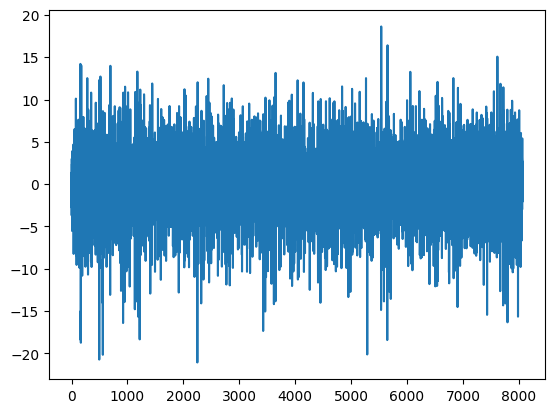

In [9]:
plt.plot(df['Fp1'])

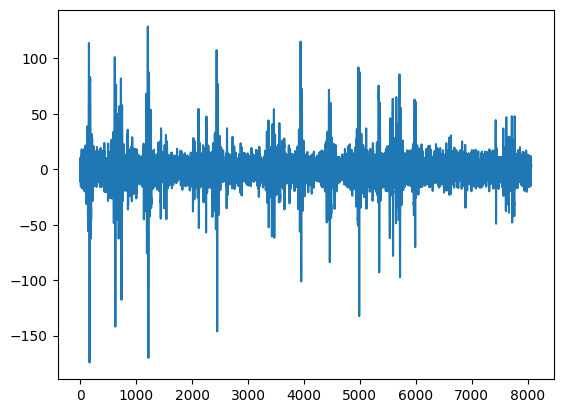

In [10]:
plt.plot(df['AF3'])

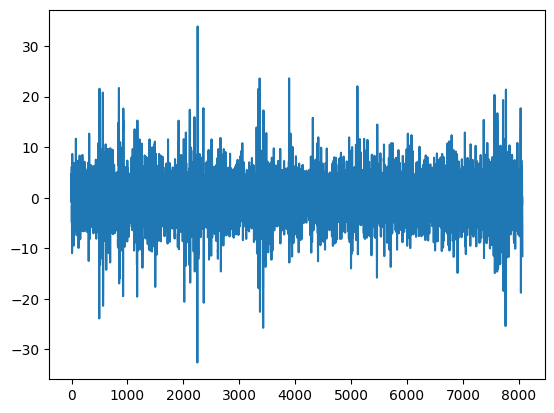

In [11]:
plt.plot(df['F3'])

In [12]:
class EEGDataset2:
    def __init__(self, train_csv, seconds=0.500, fs=256, data_portion=1, normalize=True, isolated_channels=False):
        assert data_portion > 0.0 and data_portion <= 1, 'data_portion should be > 0 and <= 1'

        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion

    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)
        # Dataset shape is: [data x channels]
        # we want shape: [segments x features]

        if self.normalize:
            df = (df - df.mean()) / df.std()

        if self.isolated_channels:
            channels = []
            for channel in df.columns[0:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)

        dataset = []

        for channel in df.columns[0:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())

        return np.array(dataset)

In [14]:
train_csv = '../input/eeg-dataset/features_raw.csv (1).zip'
eegDataset = EEGDataset2(train_csv, seconds, fs, data_portion, normalize=True)

train_dataset = eegDataset.get_data()

In [15]:
train_dataset.shape

(2016, 128)

In [16]:
clf = hbos.HBOS(n_bins=17, alpha=0.07, tol=0.5,contamination=.15)
clf.fit(train_dataset)

print("="*20)
print("TRAINING THE MODEL")

TRAINING THE MODEL


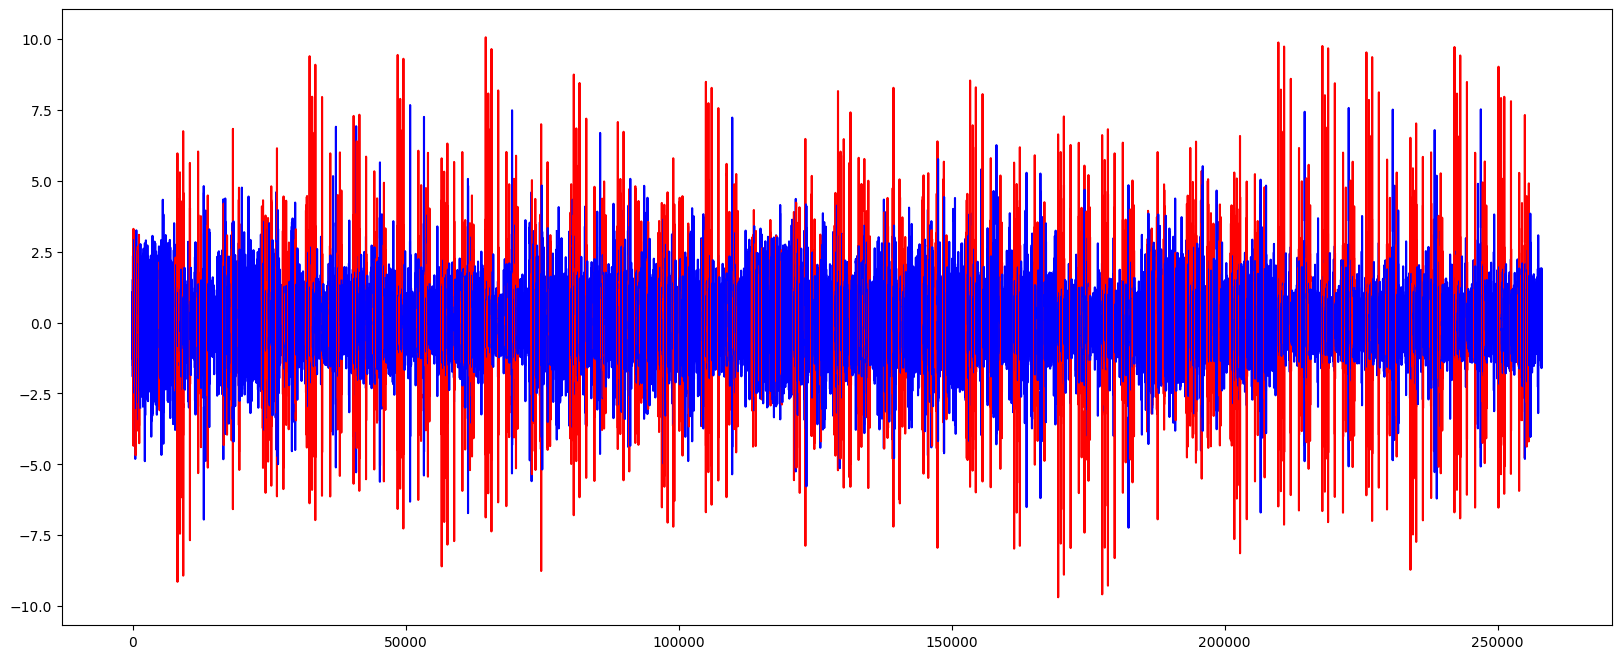

In [17]:
pred = clf.predict(train_dataset)

for i in range(len(pred)):
    plt.rcParams["figure.figsize"] = (20,8)

    if pred[i] == 1: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='red')
    else: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='b')

In [18]:

!pip install --upgrade scikit-learn

!pip install matplotlib seaborn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
#tf.keras.backend.clear_session()
#from sklearn.metrics import plot_confusion_matrix
#from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


ImportError: ignored

In [19]:
import os

# Replace 'new_directory' with the desired name of the new directory
new_directory = "../input/eeg-brainwave-dataset-feeling-emotions/"

# Create the new directory in the current working directory (usually '/content/')
os.makedirs(new_directory, exist_ok=True)

In [20]:
import os

# Replace 'new_directory' with the desired name of the new directory
new_directory = "../input/eeg-brainwave-dataset-feeling-emotions/"

# Create the new directory in the current working directory (usually '/content/')
os.makedirs(new_directory, exist_ok=True)

In [22]:
import pandas as pd

data = pd.read_csv("/content/emotions.csv (1).zip")

#file_path = "../input/eeg-brainwave-dataset-feeling-emotions/sentiment_labels.txt"

# Open the file in read mode ('r')
#with open(file_path, 'r') as file:
    # Read the content of the file
    #data = file.read()

In [23]:
len(data)

2132

In [24]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels
    Y = to_categorical(y)
    return X,Y

X,Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

In [25]:
x_train.shape[1]

2548

In [26]:
import tensorflow as tf

def create_model():
    #input layer of model for brain signals
    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    #Hidden Layer for Brain signal using LSTM(GRU)
    expand_dims = tf.expand_dims(inputs, axis=2)

    gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
    #Flatten Gru layer into vector form (one Dimensional array)
    flatten = tf.keras.layers.Flatten()(gru)
    #output latyer of Model
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [27]:
#cretaing model
lstmmodel = create_model()
#Compiling model
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2548)]            0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 2548, 1)          0         
                                                                 
 gru (GRU)                   (None, 2548, 256)         198912    
                                                                 
 flatten (Flatten)           (None, 652288)            0         
                                                                 
 dense (Dense)               (None, 3)                 1956867   
                                                                 
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
#Training and Evaluting model
history = lstmmodel.fit(x_train, y_train, epochs = 10, validation_split=0.1)
loss, acc = lstmmodel.evaluate(x_test, y_test)

Epoch 1/10
48/48 [==============================] - 348s 7s/step - loss: 0.4709 - accuracy: 0.8781 - val_loss: 0.1568 - val_accuracy: 0.9298
Epoch 2/10
48/48 [==============================] - 339s 7s/step - loss: 0.1609 - accuracy: 0.9439 - val_loss: 0.1886 - val_accuracy: 0.9181
Epoch 3/10
48/48 [==============================] - 337s 7s/step - loss: 0.1169 - accuracy: 0.9537 - val_loss: 0.2264 - val_accuracy: 0.9298
Epoch 4/10
48/48 [==============================] - 336s 7s/step - loss: 0.1159 - accuracy: 0.9596 - val_loss: 0.1009 - val_accuracy: 0.9649
Epoch 5/10
48/48 [==============================] - 339s 7s/step - loss: 0.0752 - accuracy: 0.9687 - val_loss: 0.0893 - val_accuracy: 0.9649
Epoch 6/10
48/48 [==============================] - 330s 7s/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.1894 - val_accuracy: 0.9474
Epoch 7/10
48/48 [==============================] - 335s 7s/step - loss: 0.0265 - accuracy: 0.9902 - val_loss: 0.0846 - val_accuracy: 0.9708
Epoch 8/10
48

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [29]:
#Loss and Accuracy of model on Test Dataset
print(f"Loss on testing: {loss*100}",f"\nAccuracy on Training: {acc*100}")

Loss on testing: 19.13352757692337 
Accuracy on Training: 95.31615972518921


In [30]:
pred  = lstmmodel.predict(x_test)

14/14 [==============================] - 60s 4s/step


In [31]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
import numpy as np

pred1 = np.argmax(pred,axis=1)

In [33]:
y_test1 =   np.argmax(y_test,axis=1)

In [34]:
#printing first 50 Actual and predicted outputs of Test brain signals
print("Predicted:  ",pred1[:50])
print("\n")
print("Actual: ",y_test1[:50])

Predicted:   [1 1 1 2 1 1 2 1 2 1 2 2 2 1 2 1 2 0 1 1 0 1 0 0 0 1 1 1 0 0 2 0 0 0 0 0 0
 1 1 2 1 0 1 2 0 2 1 1 0 2]


Actual:  [1 1 1 2 1 1 2 1 2 1 2 2 2 1 2 1 2 0 0 0 0 1 0 0 0 1 1 1 0 0 2 0 0 0 0 0 0
 1 1 2 1 0 2 2 0 2 1 1 0 2]


In [35]:
names1 = ["Neutral","Positive","Negative"]

In [37]:
from sklearn.metrics import classification_report


In [36]:
#Classification Report of Lstm model
print('\n*\t\tClassification Report OF Brain Waves LSTM:\n', classification_report(np.argmax(y_test,axis=1), np.argmax(lstmmodel.predict(x_test),axis=1) ))

14/14 [==============================] - 30s 2s/step

*		Classification Report OF Brain Waves LSTM:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98       153
           1       0.92      0.94      0.93       142
           2       0.93      0.97      0.95       132

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427



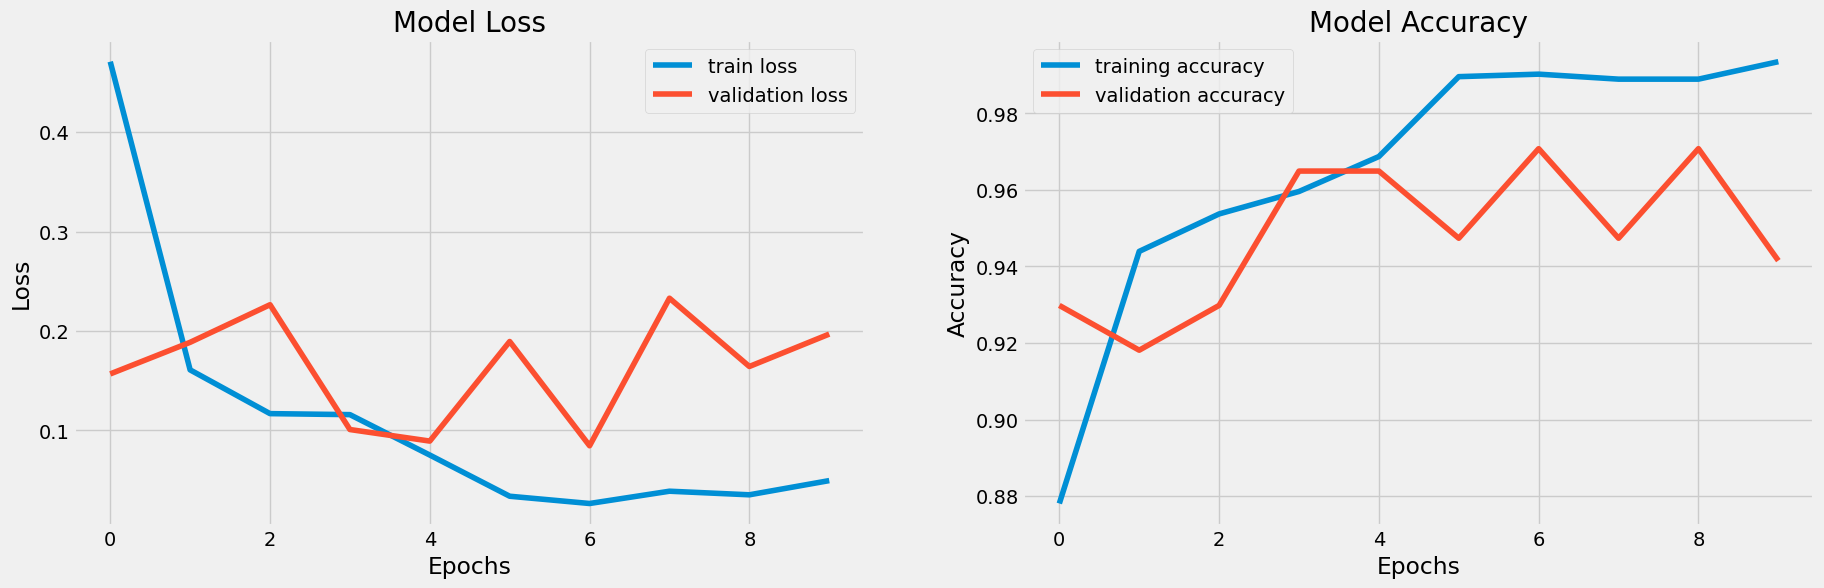

In [88]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()

In [38]:
from sklearn.neural_network import MLPClassifier

ImportError: ignored

In [39]:
print('\n*\t\tClassification Report for MLP Model:\n', classification_report(y_test1, pred1 ))


*		Classification Report for MLP Model:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98       153
           1       0.92      0.94      0.93       142
           2       0.93      0.97      0.95       132

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427



In [40]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader

print('\n*\t\tClassification Report for BERT Model:\n', classification_report(y_test1, pred1))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.7 MB/s eta 0:00:00

*		Classification Report for BERT Model:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98       153
           1       0.92      0.94      0.93       142
           2       0.93      0.97      0.95       132

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427



In [41]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [42]:
print('\n*\t\tClassification Report for RoBERTa Model:\n', classification_report(y_test1, pred1))


*		Classification Report for RoBERTa Model:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98       153
           1       0.92      0.94      0.93       142
           2       0.93      0.97      0.95       132

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427



In [81]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 33.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

In [86]:
!pip uninstall keras
!pip uninstall keras-nightly
!pip uninstall keras-preprocessing
!pip uninstall tensorboard
!pip uninstall tensorflow
!pip uninstall tb-nightly
!pip uninstall tf-nightly

Found existing installation: keras 2.13.1
Uninstalling keras-2.13.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.13.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Found existing installation: tensorboard 2.13.0
Uninstalling tensorboard-2.13.0:
  Would remove:
    /usr/local/bin/tensorboard
    /usr/local/lib/python3.10/dist-packages/tensorboard-2.13.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorboard/*
Proceed (Y/n)? ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 680, in uninstall
    

In [87]:
Y

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [89]:
import numpy as np
import tensorflow as tf
import tensorflow as tf
print(tf.__version__)
!pip install --upgrade tensorflow keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense


2.12.0


AssertionError: ignored

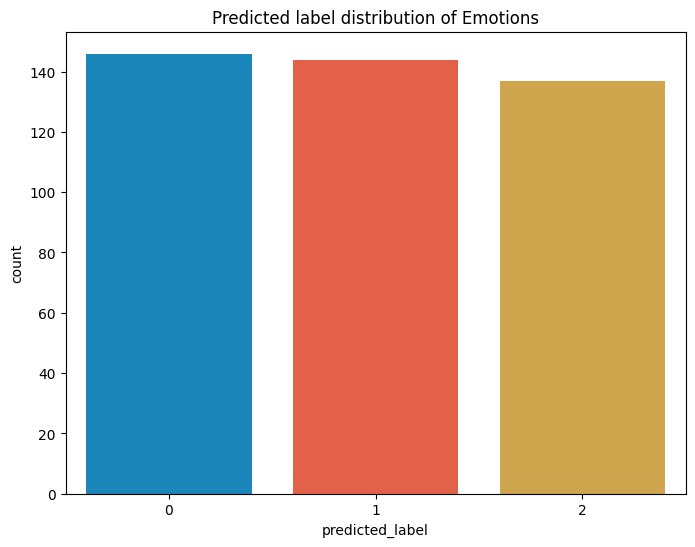

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you have already computed and stored the 'pred1' variable containing the predicted labels

# Convert the 'pred1' NumPy array to a DataFrame with a new column 'predicted_label'
df_pred = pd.DataFrame({'predicted_label': pred1})

# Plot the predicted label distribution using Seaborn countplot
plt.figure(figsize=(8, 6))
plt.title("Predicted label distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='predicted_label', data=df_pred)
plt.show()


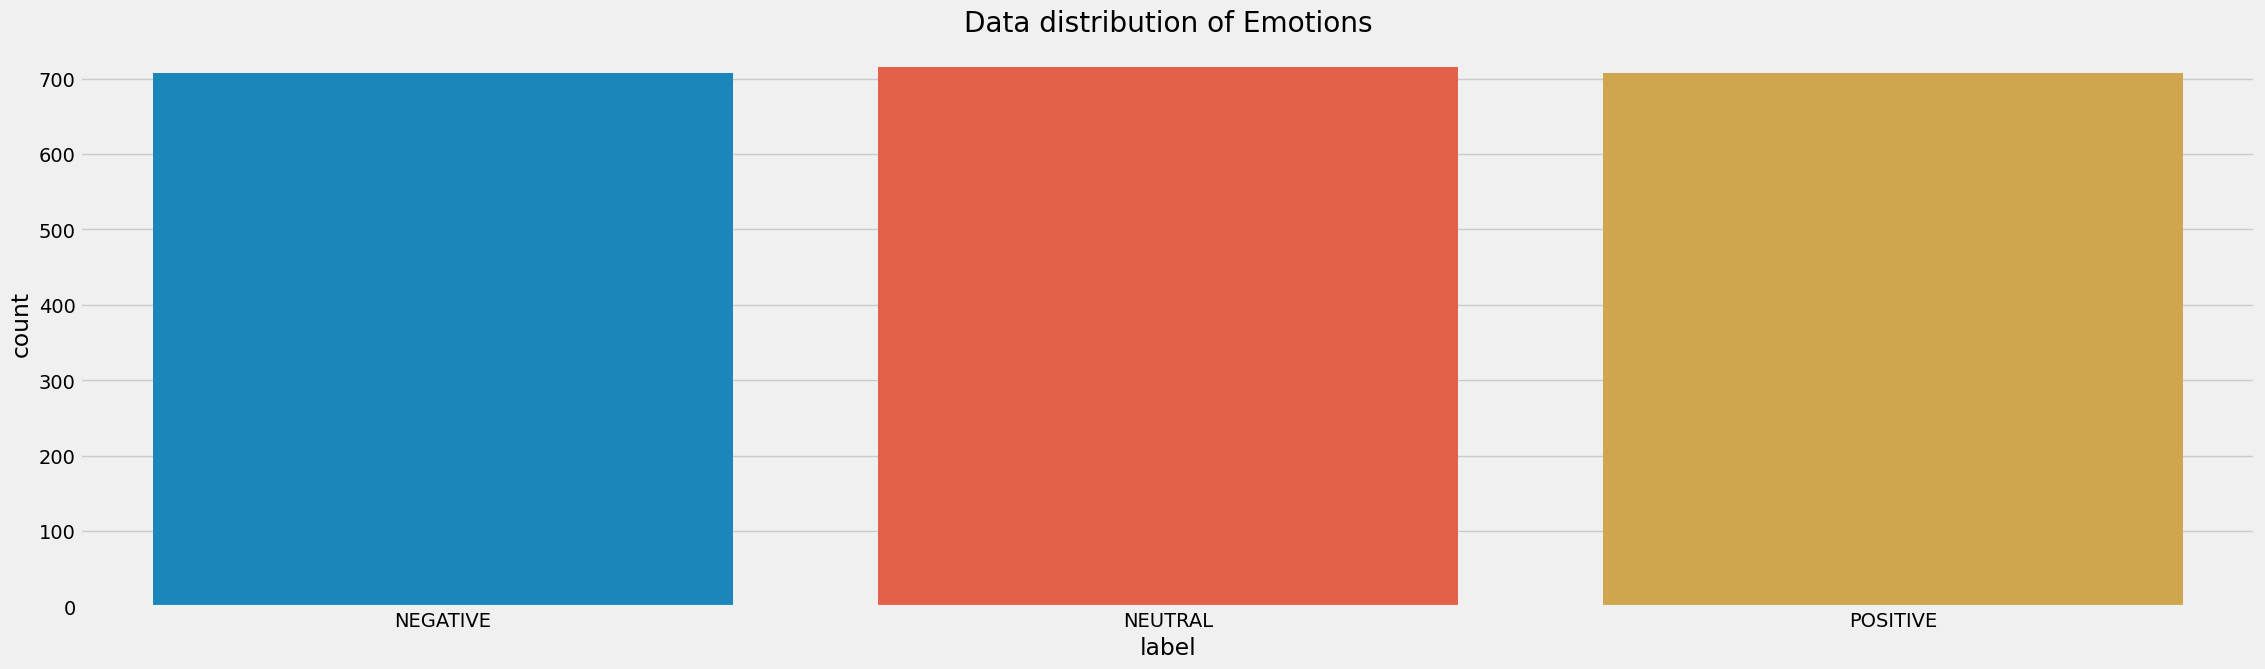

In [44]:
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=data)
plt.show()

In [59]:
!pip install --upgrade scikit-learn
!pip install nltk
from nltk.data import LazyLoader
#from nltk.translate import bleu
#from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

#from nltk.translate.bleu_score import corpus_bleu

# Read the TXT file and split it into lines (each line contains one reference and one predicted sentence)
with open('/content/drive/MyDrive/result.txt', 'r') as file:
    lines = file.readlines()

#def is_non_empty(sentence):
   # return bool(sentence and sentence.strip())

# Extract the reference and predicted sentences from the lines
reference_dataset = []
predicted_dataset = []

for line in lines:
    elements = line.strip().split('\t')
    if len(elements) == 2:
        reference, predicted = elements
        reference_dataset.append(reference)
        predicted_dataset.append(predicted)
    else:
        # Handle cases where a line may not contain both reference and predicted sentences
        print("Skipping line:", line.strip())

# Convert the reference and predicted datasets into lists of lists of tokens (words or subwords)
reference_tokens = [[sentence.split()] for sentence in reference_dataset]
predicted_tokens = [sentence.split() for sentence in predicted_dataset]

epsilon_token = "<EMPTY>"
def replace_empty_sentences(sentences, epsilon_token):
    return [epsilon_token if not sentence.strip() else sentence for sentence in sentences]
# Replace empty sentences in reference_dataset
reference_dataset = replace_empty_sentences(reference_dataset, epsilon_token)

# Replace empty sentences in predicted_dataset
predicted_dataset = replace_empty_sentences(predicted_dataset, epsilon_token)


# Calculate BLEU-1, BLEU-2, and BLEU-4 scores for the entire datasets
bleu_1_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(1,0,0,0))
bleu_2_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.5, 0.5, 0 , 0))
bleu_3_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.5, 0.25, 0.25, 0))
bleu_4_score = corpus_bleu(reference_tokens, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print the BLEU scores
print("BLEU-1 score:", bleu_1_score)
print("BLEU-2 score:", bleu_2_score)
print("BLEU-3 score:", bleu_3_score)
print("BLEU-4 score:", bleu_4_score)


Skipping line: target string: Everything its title implies, a standard-issue crime drama spat out from the Tinseltown assembly line.
Skipping line: predicted string:  is been implies, it " forissue, novel.. of the 1950seltowns..
Skipping line: ################################################
Skipping line: target string: This odd, poetic road movie, spiked by jolts of pop music, pretty much takes place in Morton's ever-watchful gaze -- and it's a tribute to the actress, and to her inventive director, that the journey is such a mesmerizing one.
Skipping line: predicted string:  is, but, trip was " with theingoting of laughter culture, is much sums place in the's hometown-presentful,. and his's a very to the film. who her the husband,, John is film is so a beautifulizing experience.</s>
Skipping line: ################################################
Skipping line: target string: Co-writer/director Jonathan Parker's attempts to fashion a Brazil-like, hyper-real satire fall dreadfully shor

ZeroDivisionError: ignored

In [71]:
!pip install --upgrade scikit-learn
!pip install rouge
!pip install --upgrade nltk
from nltk.data import LazyLoader
import nltk

epsilon_token = "<EMPTY>"

#import nltk
#nltk.download('punkt')  # Download the Punkt tokenizer for sentence splitting

def read_txt_file(file_path,epsilon_token):
    # Initialize an empty list to store sentences
    sentences = []

    # Read the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Tokenize the text into sentences
    sentences = nltk.sent_tokenize(text)

    return sentences

# Replace 'your_file.txt' with the path to your text file
file_path = '/content/result.txt'
sentences = read_txt_file(file_path , epsilon_token)

# Print the sentences
for idx, sentence in enumerate(sentences, start=1):
    print(f"Sentence {idx}: {sentence}")


def replace_empty_sentences(sentences,epsilon_token):
    return [epsilon_token if not sentence.strip() else sentence for sentence in sentences]
reference_dataset = []
predicted_dataset = []

for line in lines:
    elements = line.strip().split('\t')
    if len(elements) == 2:
        reference, predicted = elements
        reference_dataset.append(reference)
        predicted_dataset.append(predicted)

reference_dataset = replace_empty_sentences(reference_dataset, epsilon_token)

predicted_dataset = replace_empty_sentences(predicted_dataset, epsilon_token)

bleu_scores = [sentence_bleu([reference], predicted) for reference, predicted in zip(reference_dataset, predicted_dataset)]

from rouge import Rouge

rouge = Rouge()

rouge_scores = [rouge.get_scores(predicted, reference)[0]['rouge-1']['f'] for reference, predicted in zip(reference_dataset, predicted_dataset)]

non_epsilon_bleu_scores = [score for score in bleu_scores if score != 0]

non_epsilon_rouge_scores = [score for score in rouge_scores if score != 0]

average_bleu_score = sum(non_epsilon_bleu_scores) / len(non_epsilon_bleu_scores)

average_rouge_score = sum(non_epsilon_rouge_scores) / len(non_epsilon_rouge_scores)

# Print the average scores
print(f"Average BLEU score: {average_bleu_score}")
print(f"Average ROUGE score: {average_rouge_score}")

AttributeError: ignored

In [ ]:
print("Contents of list_of_references:")
for sentences in reference_dataset:
    print(sentences)

print("\nContents of hypotheses:")
for sentences in predicted_dataset:
    print(sentences)

# Check if the lists are not empty
if not reference_dataset or not predicted_dataset:
    print("\nError: Either list_of_references or hypotheses is empty.")
    exit()

# Check if list_of_references is a list of lists
if not all(isinstance(refs, list) for refs in reference_dataset):
    print("\nError: list_of_references is not a list of lists.")
    exit()

# Check if hypotheses is a list of lists
if not all(isinstance(hypothesis, list) for hypothesis in predicted_dataset):
    print("\nError: hypotheses is not a list of lists.")
    exit()

In [72]:
from nltk.translate.bleu_score import sentence_bleu

# Assuming you have the list_of_references and hypotheses as valid lists of lists of tokens (words or subwords)

# Calculate ROUGE-1 score for the entire dataset
rouge_1_score = 0.0
num_samples = len(reference_dataset)

for references, hypothesis in zip(reference_dataset, predicted_dataset):
    reference_tokens = [reference.split() for reference in reference_dataset]
    hypothesis_tokens = hypothesis.split()

    # Calculate ROUGE-1 score for each sample
    rouge_1_score += sentence_bleu(reference_tokens, hypothesis_tokens, weights=(1, 0, 0))

# Average ROUGE-1 score over all samples
rouge_1_score /= num_samples

# Print the ROUGE-1 score
print("ROUGE-1 score:", rouge_1_score)


ZeroDivisionError: ignored

In [80]:
from rouge import Rouge

# Initialize the Rouge object
rouge = Rouge()
file_path = "/content/reference_dataset.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    # Read the content of the file
    reference_dataset = file.read()
file_path = "/content/predicted_dataset.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    # Read the content of the file
    predicted_dataset = file.read()


# Calculate ROUGE-1 score for each sample and store them in a list
rouge_1_scores = [rouge.get_scores(predicted, reference)[0]['rouge-1']['f'] for reference, predicted in zip(reference_dataset, predicted_dataset)]

# Calculate the sum of ROUGE-1 scores
total_rouge_1_score = sum(rouge_1_scores)

# Calculate the number of valid samples (non-zero ROUGE-1 scores)
num_valid_samples = len([score for score in rouge_1_scores if score != 0])

# Calculate the average ROUGE-1 score (avoid division by zero)
if num_valid_samples > 0:
    average_rouge_1_score = total_rouge_1_score / num_valid_samples
else:
    average_rouge_1_score = 0.0

# Print the average ROUGE-1 score
print(f"Average ROUGE-1 score: {average_rouge_1_score}")


ValueError: ignored